In [1]:
# Dockerコンテナ動作確認
import torch
torch.cuda.is_available()

True

In [2]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [3]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # layer1
            nn.ConvTranspose2d(z_dim, image_size * 8,
                                kernel_size=4, stride=1), 
            nn.BatchNorm2d(image_size * 8), 
            nn.ReLU(inplace=True), 

            # layer2
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(image_size * 4), 
            nn.ReLU(inplace=True), 

            # layer3
            nn.ConvTranspose2d(image_size * 4, image_size * 2, 
                                kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(image_size * 2), 
            nn.ReLU(inplace=True), 

            # layer4
            nn.ConvTranspose2d(image_size * 2, image_size, 
                                kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(image_size), 
            nn.ReLU(inplace=True), 

            # layer last
            nn.ConvTranspose2d(image_size, 1, 
                                kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)


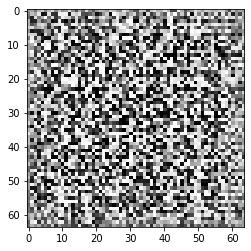

In [5]:
# Generator 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(20, 64)

# 入力する乱数, channel(z_dim)に1個ずつ乱数あげる
input_z = torch.randn(1, 20)
input_z = input_z.view(1, 20, 1, 1)#(N, C, H, W)

# 画像出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, "gray")
# imshowの引数とか https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html
plt.show()

In [6]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # layer1
            nn.Conv2d(1, image_size, 
                        kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.1, inplace=True), 

            # layer2
            nn.Conv2d(image_size, image_size * 2, 
                        kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.1, inplace=True),  

            # layer3
            nn.Conv2d(image_size * 2, image_size * 4, 
                        kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.1, inplace=True), 
            
            # layer4
            nn.Conv2d(image_size * 4, image_size * 8, 
                        kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.1, inplace=True), 

            # layer last
            nn.Conv2d(image_size * 8, 1, 
                        kernel_size=4, stride=1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)
    

    # 本の実装だとnn.Sigmoid()ないけど, nn.BCEWithLogitsLoss()がsigmoidを含んでるらしい
    # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
    # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    # 公式の DCGAN tutorial だとDiscriminator内でsigmoidかけてて, 損失関数がnn.BCELoss()になってる
    # https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers

In [7]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

#学習前なので0.5くらいが出る
print(d_out)

tensor([[[[0.5066]]]], grad_fn=<SigmoidBackward>)
